In [30]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!pip install -q kaggle scikit-learn imbalanced-learn matplotlib seaborn scipy statsmodels openpyxl

In [32]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v GiveMeSomeCredit # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: GiveMeSomeCredit
Using competition: GiveMeSomeCredit
Next Page Token = CfDJ8KYR5TFjzfZErZMgR3fFdNhb2g6KVOVemwTI41--rjgTxJrEtjfeBfEI2yKtt0vj_7SRrRz-xWdFq00ja17VQg0
teamId  teamName                                   submissionDate              score    
------  -----------------------------------------  --------------------------  -------  
  6835  Perfect Storm                              2011-12-15 05:35:00.843000  0.86955  
  7020  Gxav                                       2011-12-15 09:41:23.016000  0.86929  
  7731  occupy                                     2011-10-20 00:40:05.383000  0.86928  
  7663  D'yakonov Alexander (MSU, Moscow, Russia)  2011-12-15 22:08:19.396000  0.86919  
  9630  Indy Actuaries                             2011-12-15 18:35:33.390000  0.86913  
  8141  UCI_Combination                            2011-12-06 06:41:59.746000  0.86909  
 10197  vsh                            

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [34]:
cs_training = '/content/drive/MyDrive/cs-training.csv'
train_df = pd.read_csv(cs_training)
cs_test = '/content/drive/MyDrive/cs-test.csv'
test_df = pd.read_csv(cs_test)
sampleEntry = '/content/drive/MyDrive/sampleEntry.csv'
sample_entry = pd.read_csv(sampleEntry)

# TASK 1: EXPLORATORY DATA ANALYSIS (20%)

In [35]:
import io

def parse_excel_csv(file_path):
    df = pd.read_excel(file_path, header=None)
    headers = df.iloc[0, 0].split(',')

    data = []
    for i in range(1, len(df)):
        if pd.isna(df.iloc[i, 0]):
            continue
        row_data = str(df.iloc[i, 0]).split(',')
        data.append(row_data)

    return pd.DataFrame(data, columns=headers)

numeric_cols = ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
                'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
                'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
                'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
                'NumberOfDependents']

for col in numeric_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

print("Data Structure Overview")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:")
print(train_df.columns.tolist())
print("\nFirst 5 rows of training data:")
print(train_df.head())

print("\nData Types and Missing Values")
print("\nData types:")
print(train_df.dtypes)
print("\nMissing values in training data:")
missing_values = train_df.isnull().sum()
missing_pct = (train_df.isnull().sum() / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing %': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\nTarget Variable Analysis")
target_dist = train_df['SeriousDlqin2yrs'].value_counts()
target_pct = train_df['SeriousDlqin2yrs'].value_counts(normalize=True) * 100

print(f"Default (SeriousDlqin2yrs = 1): {target_dist[1]} cases ({target_pct[1]:.2f}%)")
print(f"Non-default (SeriousDlqin2yrs = 0): {target_dist[0]} cases ({target_pct[0]:.2f}%)")
print(f"\nClass imbalance ratio: {target_dist[0]/target_dist[1]:.2f}:1")

Data Structure Overview
Training data shape: (150000, 12)
Test data shape: (101503, 12)

Training data columns:
['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

First 5 rows of training data:
   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0         

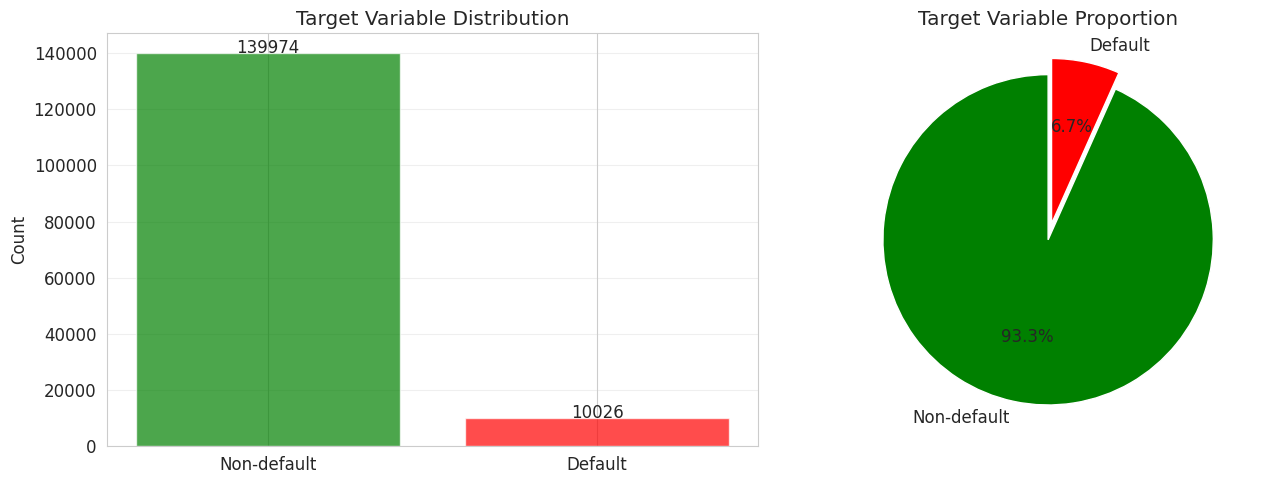

CONCLUSION: The dataset shows significant class imbalance with only 7.1% default cases.
This imbalance is important for Task 4.


In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(['Non-default', 'Default'], target_dist.values, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Count')
axes[0].set_title('Target Variable Distribution')
for i, v in enumerate(target_dist.values):
    axes[0].text(i, v + 1, str(v), ha='center')
axes[0].grid(axis='y', alpha=0.3)

axes[1].pie(target_dist.values, labels=['Non-default', 'Default'], autopct='%1.1f%%',
            colors=['green', 'red'], startangle=90, explode=(0, 0.1))
axes[1].set_title('Target Variable Proportion')

plt.tight_layout()
plt.show()

print("CONCLUSION: The dataset shows significant class imbalance with only 7.1% default cases.")
print("This imbalance is important for Task 4.")

Statistical Summary of Features

Descriptive statistics for numerical features:
       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines            age  \
count     150000.000000                         150000.000000  150000.000000   
mean           0.066840                              6.048438      52.295207   
std            0.249746                            249.755371      14.771866   
min            0.000000                              0.000000       0.000000   
25%            0.000000                              0.029867      41.000000   
50%            0.000000                              0.154181      52.000000   
75%            0.000000                              0.559046      63.000000   
max            1.000000                          50708.000000     109.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         150000.000000  150000.000000   1.202690e+05   
mean                               0.421033  

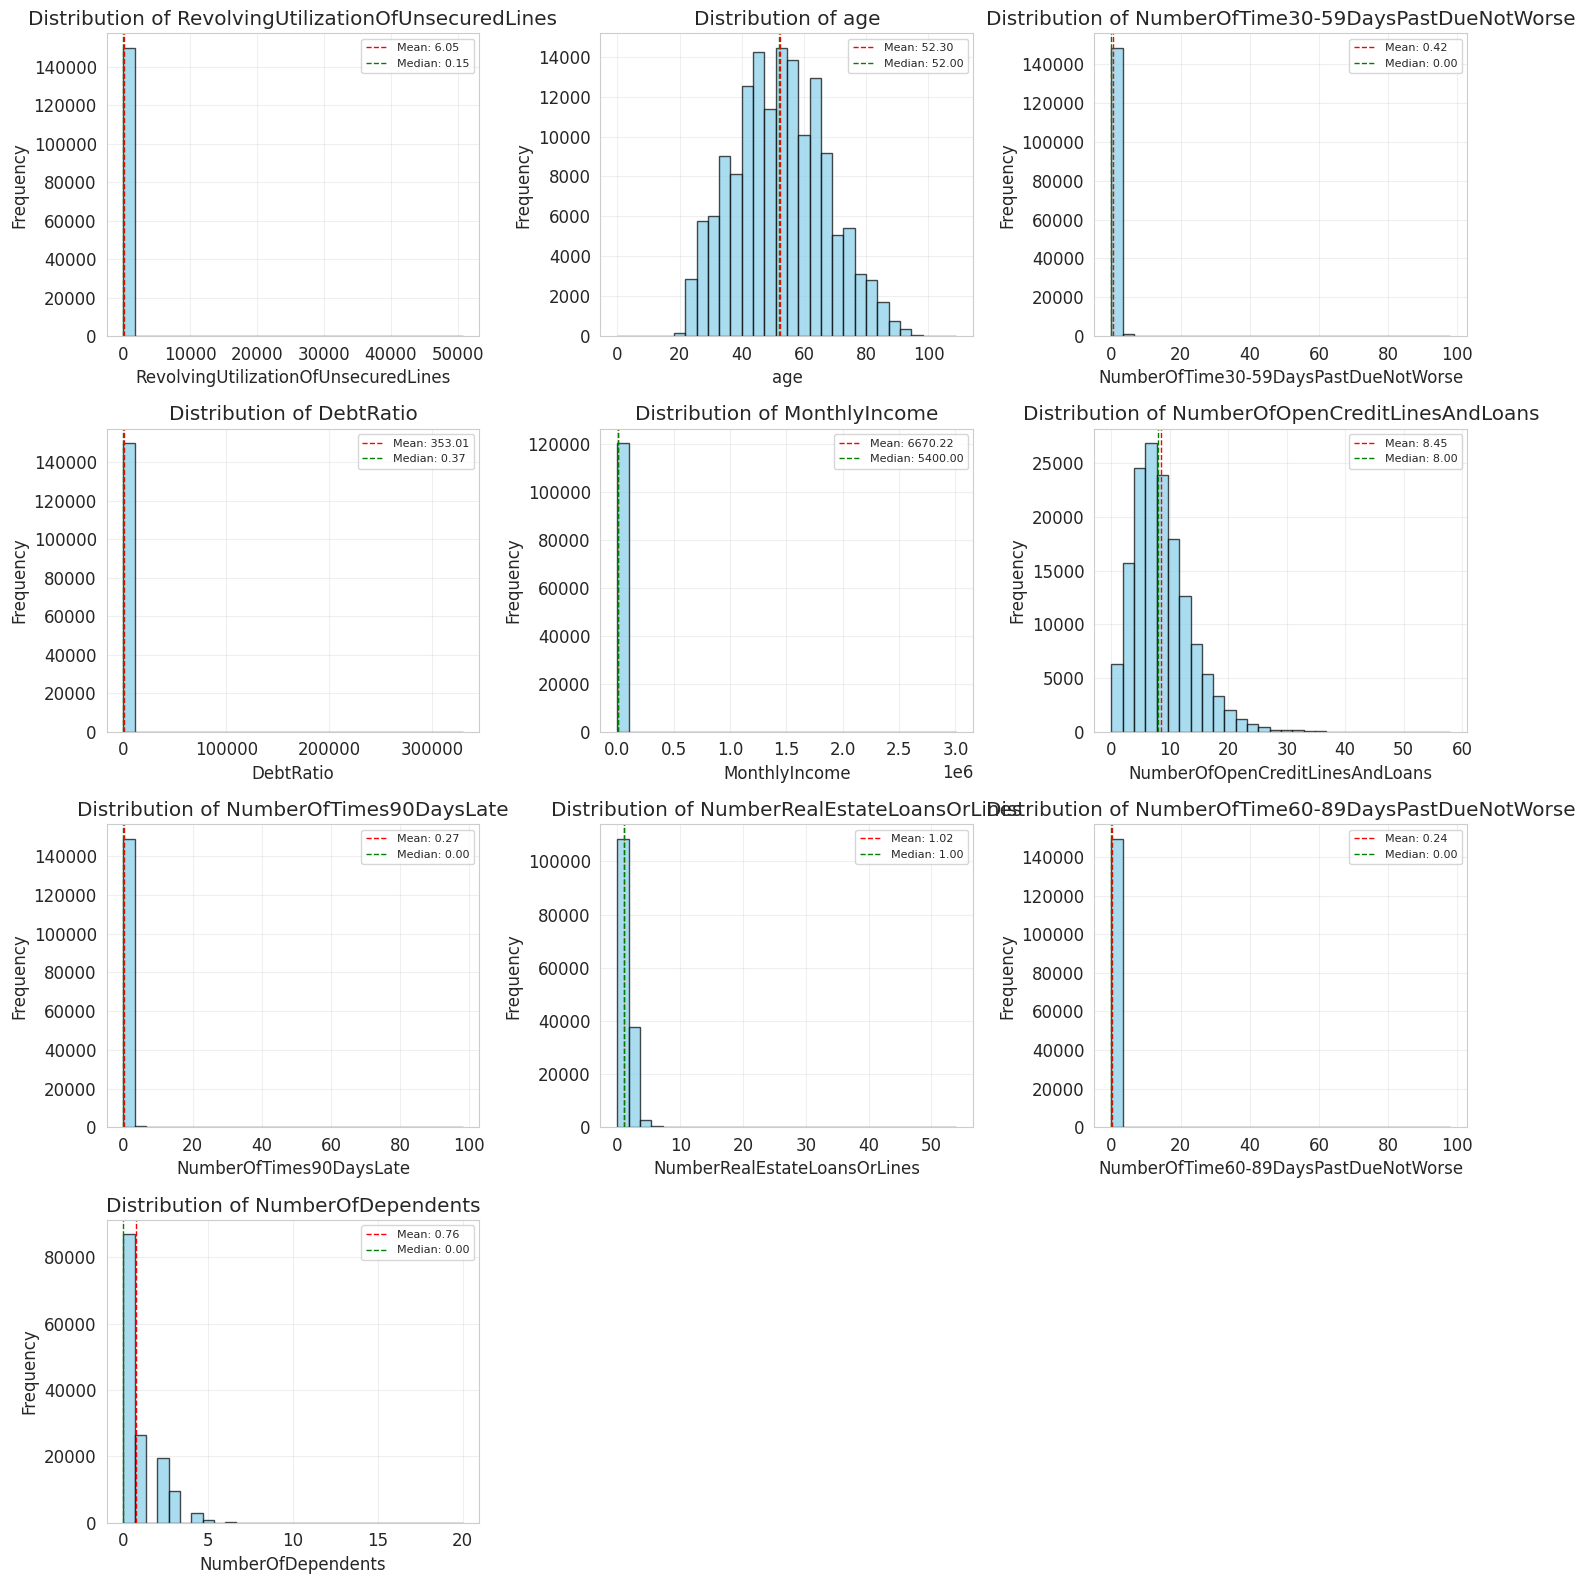


CONCLUSION: Most features show right-skewed distributions.
Features like 'RevolvingUtilizationOfUnsecuredLines' have extreme outliers.


In [37]:
print("Statistical Summary of Features")
if 'Unnamed: 0' in train_df.columns:
    train_df = train_df.drop('Unnamed: 0', axis=1)
if 'Unnamed: 0' in test_df.columns:
    test_df = test_df.drop('Unnamed: 0', axis=1)

print("\nDescriptive statistics for numerical features:")
print(train_df.describe())

print("\nDistribution of Numerical Features")
numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'SeriousDlqin2yrs' in numerical_features:
    numerical_features.remove('SeriousDlqin2yrs')

n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    data = train_df[col].dropna()
    axes[idx].hist(data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

    mean_val = data.mean()
    median_val = data.median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median: {median_val:.2f}')
    axes[idx].legend(fontsize=8)

for idx in range(len(numerical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nCONCLUSION: Most features show right-skewed distributions.")
print("Features like 'RevolvingUtilizationOfUnsecuredLines' have extreme outliers.")

Outlier Detection


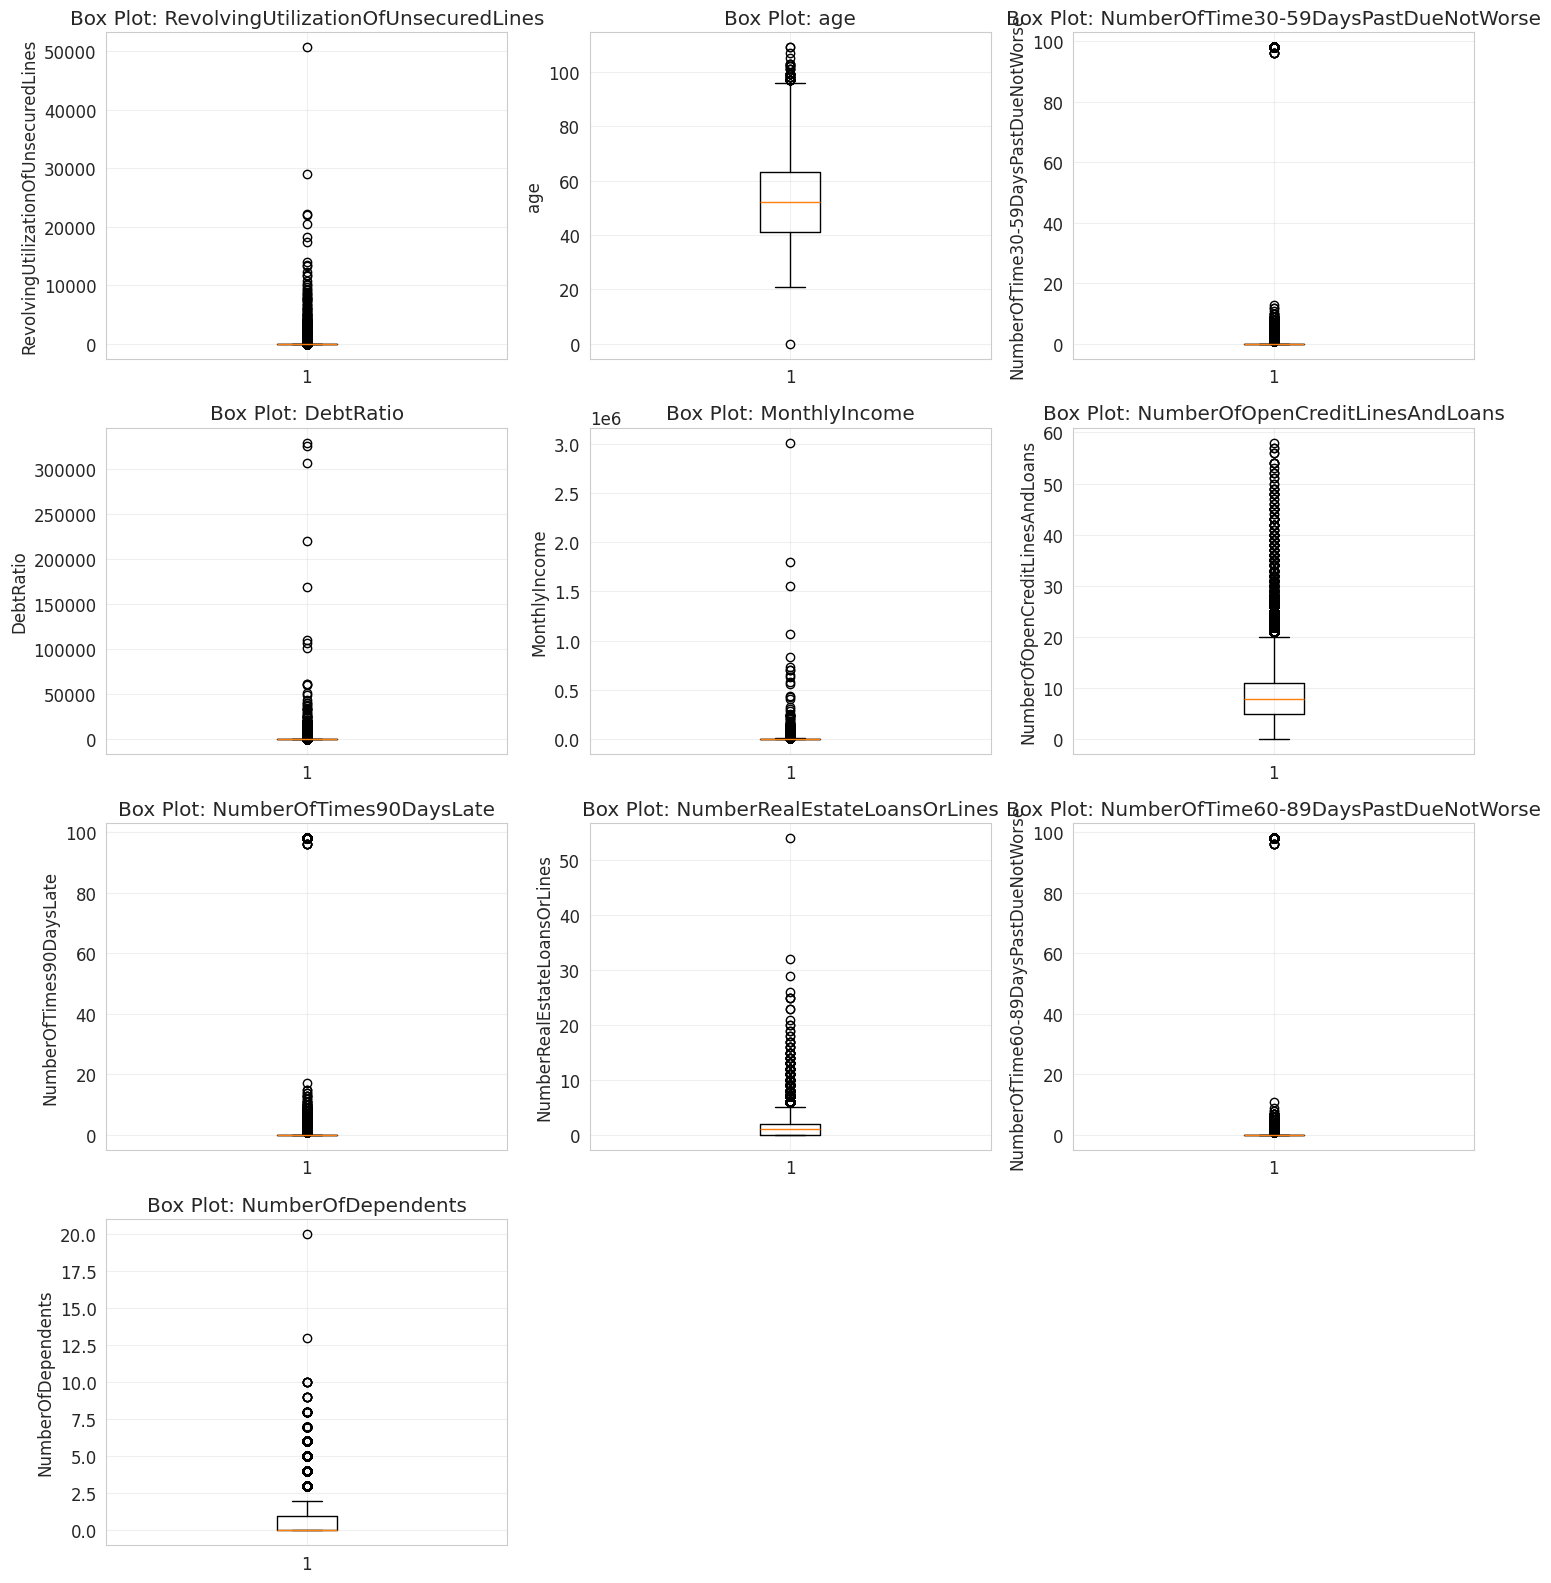


Outlier analysis using IQR method:
                                Feature  Outliers Outlier % Lower Bound  \
0  RevolvingUtilizationOfUnsecuredLines       763     0.51%       -0.76   
1                                   age        46     0.03%        8.00   
2  NumberOfTime30-59DaysPastDueNotWorse     23982    15.99%        0.00   
3                             DebtRatio     31311    20.87%       -0.86   
4                         MonthlyIncome      4879     4.06%    -3873.50   
5       NumberOfOpenCreditLinesAndLoans      3980     2.65%       -4.00   
6               NumberOfTimes90DaysLate      8338     5.56%        0.00   
7          NumberRealEstateLoansOrLines       793     0.53%       -3.00   
8  NumberOfTime60-89DaysPastDueNotWorse      7604     5.07%        0.00   
9                    NumberOfDependents     13336     9.13%       -1.50   

  Upper Bound  
0        1.35  
1       96.00  
2        0.00  
3        1.91  
4    15522.50  
5       20.00  
6        0.00  
7        5

In [38]:
print("Outlier Detection")
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    data = train_df[col].dropna()
    axes[idx].boxplot(data)
    axes[idx].set_title(f'Box Plot: {col}')
    axes[idx].set_ylabel(col)
    axes[idx].grid(alpha=0.3)

for idx in range(len(numerical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nOutlier analysis using IQR method:")
outlier_summary = []
for col in numerical_features:
    data = train_df[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    outlier_pct = (outliers / len(data)) * 100
    outlier_summary.append({
        'Feature': col,
        'Outliers': outliers,
        'Outlier %': f'{outlier_pct:.2f}%',
        'Lower Bound': f'{lower_bound:.2f}',
        'Upper Bound': f'{upper_bound:.2f}'
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df)

print("\nCONCLUSION: Multiple features contain significant outliers.")
print("These may represent legitimate extreme cases rather than errors.")

Correlation Analysis


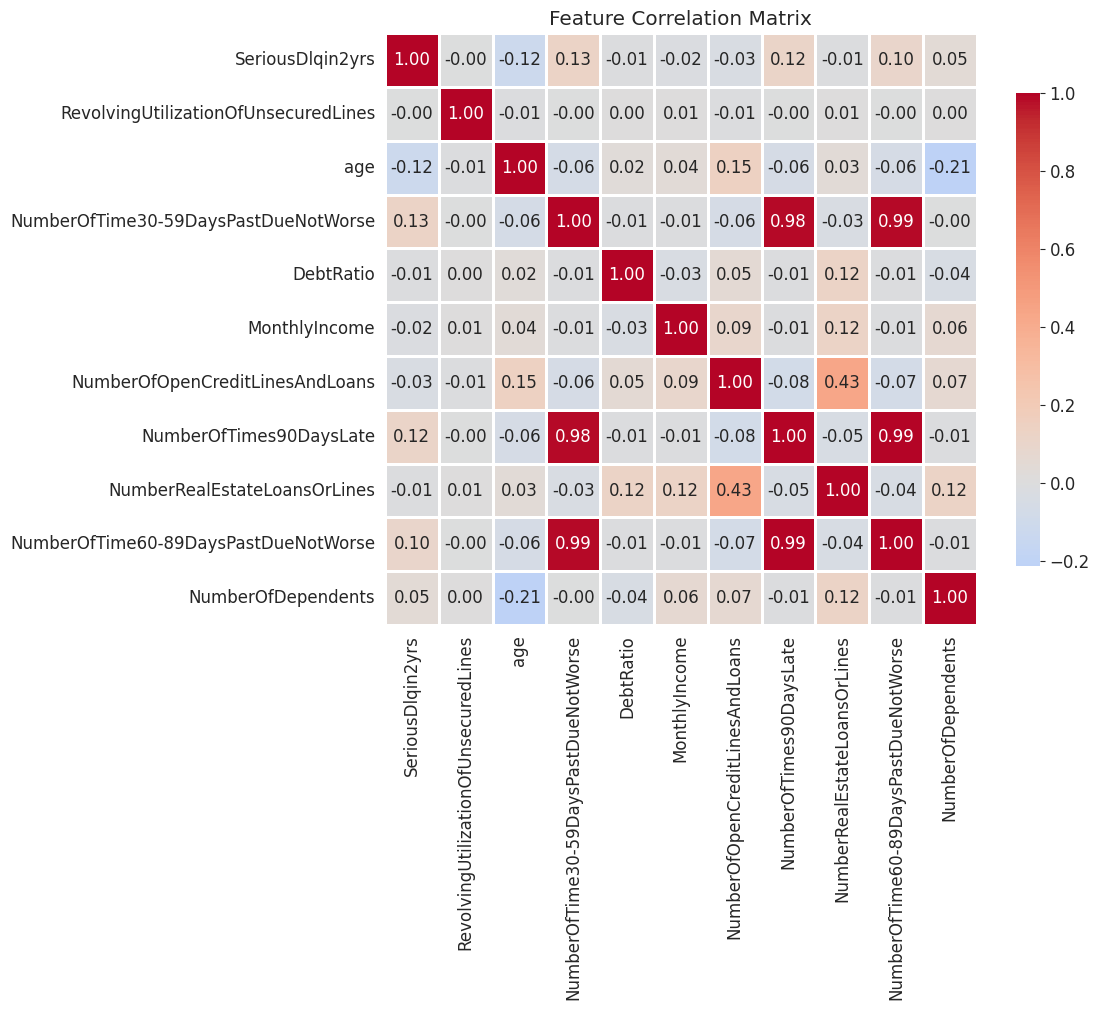


Correlation with target variable (SeriousDlqin2yrs):
NumberOfTime30-59DaysPastDueNotWorse: 0.126
NumberOfTimes90DaysLate: 0.117
NumberOfTime60-89DaysPastDueNotWorse: 0.102
NumberOfDependents: 0.046
RevolvingUtilizationOfUnsecuredLines: -0.002
NumberRealEstateLoansOrLines: -0.007
DebtRatio: -0.008
MonthlyIncome: -0.020
NumberOfOpenCreditLinesAndLoans: -0.030
age: -0.115


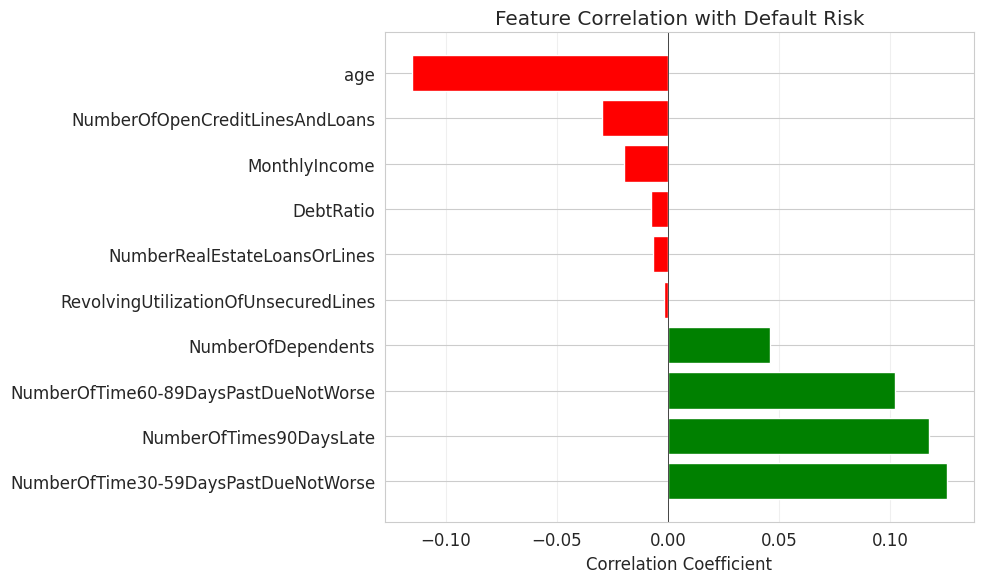


CONCLUSION: Payment delinquency features show the strongest correlation with default risk.
Age shows weak negative correlation (younger applicants are slightly riskier).


In [39]:
print("Correlation Analysis")
correlation_matrix = train_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

target_corr = correlation_matrix['SeriousDlqin2yrs'].drop('SeriousDlqin2yrs').sort_values(ascending=False)
print("\nCorrelation with target variable (SeriousDlqin2yrs):")
for feature, corr in target_corr.items():
    print(f"{feature}: {corr:.3f}")

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in target_corr.values]
plt.barh(range(len(target_corr)), target_corr.values, color=colors)
plt.yticks(range(len(target_corr)), target_corr.index)
plt.xlabel('Correlation Coefficient')
plt.title('Feature Correlation with Default Risk')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCONCLUSION: Payment delinquency features show the strongest correlation with default risk.")
print("Age shows weak negative correlation (younger applicants are slightly riskier).")

Relationship between Target and Key Features


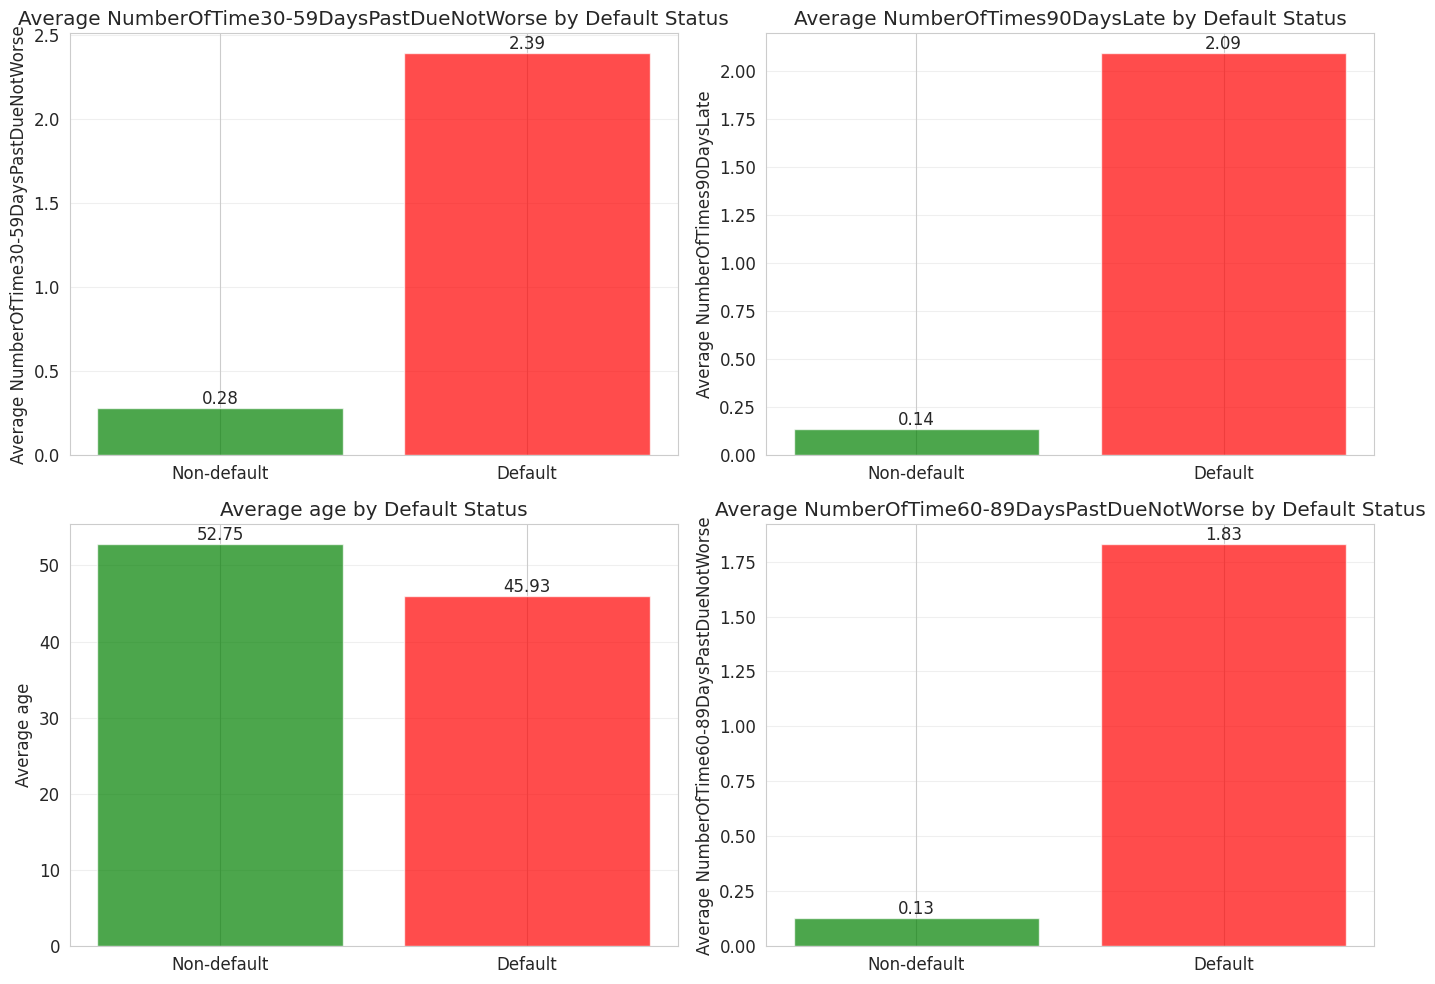


CONCLUSION: Clear differences exist between defaulters and non-defaulters.
Defaulters have higher delinquency counts and different financial ratios.


In [40]:
print("Relationship between Target and Key Features")
top_features = target_corr.abs().nlargest(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    grouped = train_df.groupby('SeriousDlqin2yrs')[feature].mean()

    axes[idx].bar(['Non-default', 'Default'], grouped.values,
                  color=['green', 'red'], alpha=0.7)
    axes[idx].set_title(f'Average {feature} by Default Status')
    axes[idx].set_ylabel(f'Average {feature}')
    axes[idx].grid(axis='y', alpha=0.3)

    for i, v in enumerate(grouped.values):
        axes[idx].text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nCONCLUSION: Clear differences exist between defaulters and non-defaulters.")
print("Defaulters have higher delinquency counts and different financial ratios.")

Age Analysis


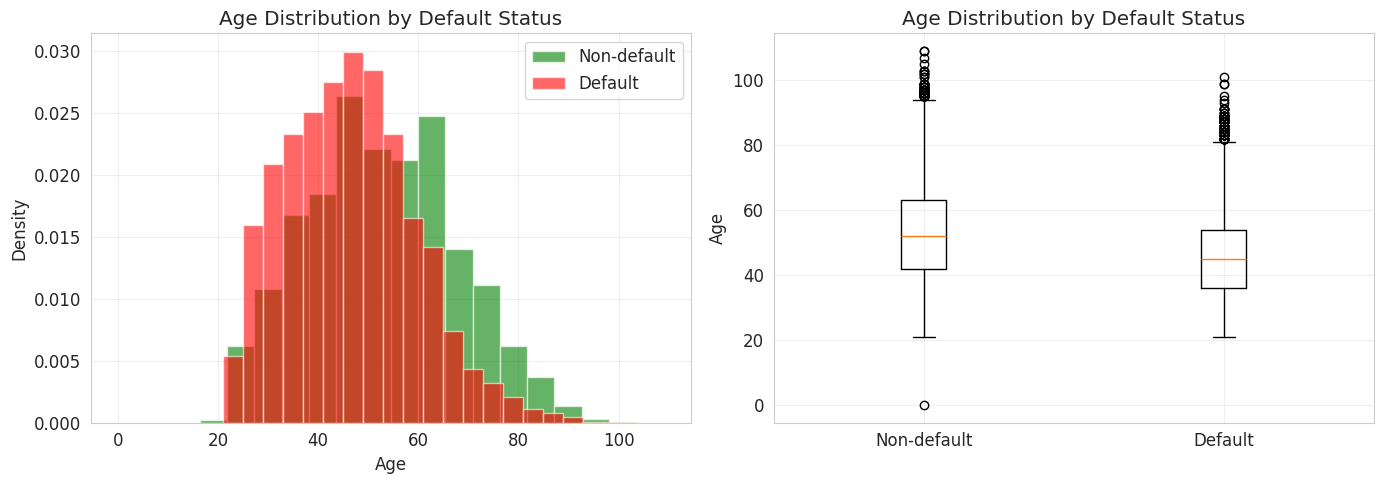

Average age of non-defaulters: 52.8
Average age of defaulters: 45.9
Age difference: 6.8 years

CONCLUSION: Defaulters tend to be slightly younger on average.


In [41]:
print("Age Analysis")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
non_default_age = train_df[train_df['SeriousDlqin2yrs'] == 0]['age'].dropna()
default_age = train_df[train_df['SeriousDlqin2yrs'] == 1]['age'].dropna()

axes[0].hist(non_default_age, bins=20, alpha=0.6, color='green', label='Non-default', density=True)
axes[0].hist(default_age, bins=20, alpha=0.6, color='red', label='Default', density=True)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Density')
axes[0].set_title('Age Distribution by Default Status')
axes[0].legend()
axes[0].grid(alpha=0.3)

age_data = [non_default_age, default_age]
axes[1].boxplot(age_data, labels=['Non-default', 'Default'])
axes[1].set_ylabel('Age')
axes[1].set_title('Age Distribution by Default Status')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average age of non-defaulters: {non_default_age.mean():.1f}")
print(f"Average age of defaulters: {default_age.mean():.1f}")
print(f"Age difference: {non_default_age.mean() - default_age.mean():.1f} years")

print("\nCONCLUSION: Defaulters tend to be slightly younger on average.")

# TASK 2: CREATING ADDITIONAL VARIABLES (10%)

In [42]:
train_df_fe = train_df.copy()
test_df_fe = test_df.copy()

print(f"Original number of features: {train_df.shape[1] - 1}")
print("\nTotal Late Payments Feature")
train_df_fe['TotalLatePayments'] = (
    train_df_fe['NumberOfTime30-59DaysPastDueNotWorse'] +
    train_df_fe['NumberOfTime60-89DaysPastDueNotWorse'] +
    train_df_fe['NumberOfTimes90DaysLate']
)
test_df_fe['TotalLatePayments'] = (
    test_df_fe['NumberOfTime30-59DaysPastDueNotWorse'] +
    test_df_fe['NumberOfTime60-89DaysPastDueNotWorse'] +
    test_df_fe['NumberOfTimes90DaysLate']
)
print("Created: TotalLatePayments")
print(f"  Range: {train_df_fe['TotalLatePayments'].min()} to {train_df_fe['TotalLatePayments'].max()}")
print(f"  Correlation with target: {train_df_fe['TotalLatePayments'].corr(train_df_fe['SeriousDlqin2yrs']):.3f}")

print("\nCredit Utilization Categories")
def categorize_utilization(util):
    if util <= 0.3:
        return 'Low'
    elif util <= 0.7:
        return 'Medium'
    elif util <= 1.0:
        return 'High'
    else:
        return 'Extreme'

train_df_fe['UtilizationCategory'] = train_df_fe['RevolvingUtilizationOfUnsecuredLines'].apply(categorize_utilization)
test_df_fe['UtilizationCategory'] = test_df_fe['RevolvingUtilizationOfUnsecuredLines'].apply(categorize_utilization)
util_mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Extreme': 3}
train_df_fe['UtilizationCategory_Num'] = train_df_fe['UtilizationCategory'].map(util_mapping)
test_df_fe['UtilizationCategory_Num'] = test_df_fe['UtilizationCategory'].map(util_mapping)
print("Created: UtilizationCategory_Num")
print("  Distribution:", train_df_fe['UtilizationCategory'].value_counts().to_dict())

Original number of features: 10

Total Late Payments Feature
Created: TotalLatePayments
  Range: 0 to 294
  Correlation with target: 0.116

Credit Utilization Categories
Created: UtilizationCategory_Num
  Distribution: {'Low': 92882, 'Medium': 27170, 'High': 26627, 'Extreme': 3321}


In [43]:
print("Age Groups")
def categorize_age(age):
    if age < 25:
        return 'Young'
    elif age < 35:
        return 'Young Adult'
    elif age < 50:
        return 'Middle Aged'
    elif age < 65:
        return 'Senior'
    else:
        return 'Elderly'

train_df_fe['AgeGroup'] = train_df_fe['age'].apply(categorize_age)
test_df_fe['AgeGroup'] = test_df_fe['age'].apply(categorize_age)

age_mapping = {'Young': 0, 'Young Adult': 1, 'Middle Aged': 2, 'Senior': 3, 'Elderly': 4}
train_df_fe['AgeGroup_Num'] = train_df_fe['AgeGroup'].map(age_mapping)
test_df_fe['AgeGroup_Num'] = test_df_fe['AgeGroup'].map(age_mapping)
print("Created: AgeGroup_Num")
print("Distribution:", train_df_fe['AgeGroup'].value_counts().to_dict())

print("\nDebt-to-Income Ratio")
train_median_income = train_df_fe['MonthlyIncome'].median()
test_median_income = test_df_fe['MonthlyIncome'].median()

train_df_fe['MonthlyIncome'] = train_df_fe['MonthlyIncome'].fillna(train_median_income)
test_df_fe['MonthlyIncome'] = test_df_fe['MonthlyIncome'].fillna(test_median_income)

train_df_fe['DebtToIncome'] = train_df_fe['DebtRatio'] * train_df_fe['MonthlyIncome']
test_df_fe['DebtToIncome'] = test_df_fe['DebtRatio'] * test_df_fe['MonthlyIncome']

train_df_fe['DebtToIncome_Log'] = np.log1p(train_df_fe['DebtToIncome'])
test_df_fe['DebtToIncome_Log'] = np.log1p(test_df_fe['DebtToIncome'])
print("Created: DebtToIncome_Log")
print(f"  Range: {train_df_fe['DebtToIncome_Log'].min():.2f} to {train_df_fe['DebtToIncome_Log'].max():.2f}")


Age Groups
Created: AgeGroup_Num
Distribution: {'Senior': 52426, 'Middle Aged': 47141, 'Elderly': 31193, 'Young Adult': 17165, 'Young': 2075}

Debt-to-Income Ratio
Created: DebtToIncome_Log
  Range: 0.00 to 21.30


In [44]:
print("Payment Behavior Score")
train_df_fe['PaymentBehaviorScore'] = (
    train_df_fe['NumberOfTime30-59DaysPastDueNotWorse'] * 0.3 +
    train_df_fe['NumberOfTime60-89DaysPastDueNotWorse'] * 0.5 +
    train_df_fe['NumberOfTimes90DaysLate'] * 1.0
)
test_df_fe['PaymentBehaviorScore'] = (
    test_df_fe['NumberOfTime30-59DaysPastDueNotWorse'] * 0.3 +
    test_df_fe['NumberOfTime60-89DaysPastDueNotWorse'] * 0.5 +
    test_df_fe['NumberOfTimes90DaysLate'] * 1.0
)
print("Created: PaymentBehaviorScore")
print(f"  Range: {train_df_fe['PaymentBehaviorScore'].min():.2f} to {train_df_fe['PaymentBehaviorScore'].max():.2f}")

print("\nCredit Lines per Dependent")
train_df_fe['NumberOfDependents'] = train_df_fe['NumberOfDependents'].fillna(0)
test_df_fe['NumberOfDependents'] = test_df_fe['NumberOfDependents'].fillna(0)
train_df_fe['CreditLinesPerDependent'] = np.where(
    train_df_fe['NumberOfDependents'] > 0,
    train_df_fe['NumberOfOpenCreditLinesAndLoans'] / train_df_fe['NumberOfDependents'],
    train_df_fe['NumberOfOpenCreditLinesAndLoans']
)
test_df_fe['CreditLinesPerDependent'] = np.where(
    test_df_fe['NumberOfDependents'] > 0,
    test_df_fe['NumberOfOpenCreditLinesAndLoans'] / test_df_fe['NumberOfDependents'],
    test_df_fe['NumberOfOpenCreditLinesAndLoans']
)

train_df_fe['CreditLinesPerDependent'] = train_df_fe['CreditLinesPerDependent'].clip(upper=20)
test_df_fe['CreditLinesPerDependent'] = test_df_fe['CreditLinesPerDependent'].clip(upper=20)
print("Created: CreditLinesPerDependent")
print(f"  Range: {train_df_fe['CreditLinesPerDependent'].min():.2f} to {train_df_fe['CreditLinesPerDependent'].max():.2f}")


Payment Behavior Score
Created: PaymentBehaviorScore
  Range: 0.00 to 176.40

Credit Lines per Dependent
Created: CreditLinesPerDependent
  Range: 0.00 to 20.00


In [45]:
print("Has Serious Delinquency Indicator")
train_df_fe['HasSeriousDelinquency'] = (
    (train_df_fe['NumberOfTime60-89DaysPastDueNotWorse'] > 0) |
    (train_df_fe['NumberOfTimes90DaysLate'] > 0)
).astype(int)
test_df_fe['HasSeriousDelinquency'] = (
    (test_df_fe['NumberOfTime60-89DaysPastDueNotWorse'] > 0) |
    (test_df_fe['NumberOfTimes90DaysLate'] > 0)
).astype(int)
print("Created: HasSeriousDelinquency")
print(f"  Percentage with serious delinquency: {train_df_fe['HasSeriousDelinquency'].mean()*100:.1f}%")

print("\nSummary of New Features")
new_features = [
    'TotalLatePayments', 'UtilizationCategory_Num', 'AgeGroup_Num',
    'DebtToIncome_Log', 'PaymentBehaviorScore',
    'CreditLinesPerDependent', 'HasSeriousDelinquency'
]

print(f"\nTotal new features created: {len(new_features)}")
print("New features:", new_features)
print("\nCorrelation of new features with target:")
for feature in new_features:
    if feature in train_df_fe.columns:
        corr = train_df_fe[feature].corr(train_df_fe['SeriousDlqin2yrs'])
        print(f"  {feature}: {corr:.3f}")
print(f"\nTotal features now: {train_df_fe.shape[1] - 1}")

Has Serious Delinquency Indicator
Created: HasSeriousDelinquency
  Percentage with serious delinquency: 8.8%

Summary of New Features

Total new features created: 7
New features: ['TotalLatePayments', 'UtilizationCategory_Num', 'AgeGroup_Num', 'DebtToIncome_Log', 'PaymentBehaviorScore', 'CreditLinesPerDependent', 'HasSeriousDelinquency']

Correlation of new features with target:
  TotalLatePayments: 0.116
  UtilizationCategory_Num: 0.285
  AgeGroup_Num: -0.110
  DebtToIncome_Log: -0.010
  PaymentBehaviorScore: 0.115
  CreditLinesPerDependent: -0.043
  HasSeriousDelinquency: 0.361

Total features now: 20


# TASK 3: MODEL BUILDING WITH WOE TRANSFORMATION (50%)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("Data Preparation and Train-Test Split")
features_for_modeling = [
    'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
    'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents',
    'TotalLatePayments', 'UtilizationCategory_Num', 'AgeGroup_Num',
    'DebtToIncome_Log', 'PaymentBehaviorScore',
    'CreditLinesPerDependent', 'HasSeriousDelinquency'
]

available_features = [f for f in features_for_modeling if f in train_df_fe.columns]
print(f"Available features for modeling: {len(available_features)}")

X = train_df_fe[available_features]
y = train_df_fe['SeriousDlqin2yrs']
X = X.fillna(X.median())
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Target distribution in training: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Target distribution in validation: {y_val.value_counts(normalize=True).to_dict()}")

print("\nWoE Transformation - Fine Classification")

def calculate_woe_iv(df, feature, target, bins=20):
    df_temp = df[[feature, target]].copy()
    df_temp = df_temp.dropna()

    try:
        df_temp['bin'] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
    except:
        unique_vals = df_temp[feature].nunique()
        if unique_vals <= bins:
            df_temp['bin'] = df_temp[feature]
        else:
            df_temp['bin'] = pd.cut(df_temp[feature], bins=bins, duplicates='drop')

    grouped = df_temp.groupby('bin', observed=False)[target].agg(['count', 'sum'])
    grouped.columns = ['Total', 'Bad']
    grouped['Good'] = grouped['Total'] - grouped['Bad']
    total_good = grouped['Good'].sum()
    total_bad = grouped['Bad'].sum()
    epsilon = 0.0001
    grouped['Dist_Good'] = (grouped['Good'] + epsilon) / (total_good + 2*epsilon)
    grouped['Dist_Bad'] = (grouped['Bad'] + epsilon) / (total_bad + 2*epsilon)
    grouped['WoE'] = np.log(grouped['Dist_Good'] / grouped['Dist_Bad'])
    grouped['IV'] = (grouped['Dist_Good'] - grouped['Dist_Bad']) * grouped['WoE']
    iv_total = grouped['IV'].sum()

    return grouped, iv_total

woe_tables = {}
iv_values = {}

for feature in available_features[:10]:
    try:
        woe_table, iv = calculate_woe_iv(
            pd.concat([X_train, y_train], axis=1),
            feature, 'SeriousDlqin2yrs', bins=20
        )
        woe_tables[feature] = woe_table
        iv_values[feature] = iv
        print(f"  {feature}: IV = {iv:.4f}")
    except Exception as e:
        print(f"  {feature}: Error - {str(e)[:50]}...")

iv_df = pd.DataFrame.from_dict(iv_values, orient='index', columns=['IV'])
iv_df = iv_df.sort_values('IV', ascending=False)

print("\nTop features by Information Value:")
print(iv_df.head(10))

print("\nIV Interpretation Guide:")
print("  < 0.02: Not useful")
print("  0.02 - 0.1: Weak predictor")
print("  0.1 - 0.3: Medium predictor")
print("  0.3 - 0.5: Strong predictor")
print("  > 0.5: Suspiciously good")


Data Preparation and Train-Test Split
Available features for modeling: 17
Training set: 105000 samples
Validation set: 45000 samples
Target distribution in training: {0: 0.9331619047619047, 1: 0.06683809523809524}
Target distribution in validation: {0: 0.9331555555555555, 1: 0.06684444444444444}

WoE Transformation - Fine Classification
  RevolvingUtilizationOfUnsecuredLines: IV = 1.1596
  age: IV = 0.2454
  NumberOfTime30-59DaysPastDueNotWorse: IV = 0.4810
  DebtRatio: IV = 0.0820
  MonthlyIncome: IV = 0.0799
  NumberOfOpenCreditLinesAndLoans: IV = 0.0864
  NumberOfTimes90DaysLate: IV = 0.4860
  NumberRealEstateLoansOrLines: IV = 0.0179
  NumberOfTime60-89DaysPastDueNotWorse: IV = 0.2607
  NumberOfDependents: IV = 0.0238

Top features by Information Value:
                                            IV
RevolvingUtilizationOfUnsecuredLines  1.159569
NumberOfTimes90DaysLate               0.485979
NumberOfTime30-59DaysPastDueNotWorse  0.481024
NumberOfTime60-89DaysPastDueNotWorse  0.2606

In [47]:
print("WoE Transformation - Coarse Classification")

def coarse_classification(feature_series, woe_table, n_bins=5):
    bins = pd.qcut(feature_series, q=n_bins, duplicates='drop', retbins=True)[1]
    return bins

top_features = iv_df.head(5).index.tolist()
coarse_woe_maps = {}

for feature in top_features:
    try:
        woe_table = woe_tables[feature]
        feature_data = X_train[feature].dropna()
        coarse_bins = pd.qcut(feature_data, q=5, duplicates='drop', retbins=True)[1]
        bin_labels = []
        for i in range(len(coarse_bins)-1):
            bin_labels.append(f"[{coarse_bins[i]:.3f}, {coarse_bins[i+1]:.3f})")
        feature_coarse = pd.cut(feature_data, bins=coarse_bins, labels=bin_labels, include_lowest=True)
        coarse_df = pd.DataFrame({
            'feature': feature_data,
            'bin': feature_coarse,
            'target': y_train[feature_data.index]
        })

        coarse_grouped = coarse_df.groupby('bin', observed=False)['target'].agg(['count', 'sum'])
        coarse_grouped.columns = ['Total', 'Bad']
        coarse_grouped['Good'] = coarse_grouped['Total'] - coarse_grouped['Bad']

        epsilon = 0.0001
        total_good = coarse_grouped['Good'].sum()
        total_bad = coarse_grouped['Bad'].sum()

        coarse_grouped['Dist_Good'] = (coarse_grouped['Good'] + epsilon) / (total_good + 2*epsilon)
        coarse_grouped['Dist_Bad'] = (coarse_grouped['Bad'] + epsilon) / (total_bad + 2*epsilon)
        coarse_grouped['WoE'] = np.log(coarse_grouped['Dist_Good'] / coarse_grouped['Dist_Bad'])

        coarse_woe_maps[feature] = coarse_grouped['WoE'].to_dict()

        print(f"\n  {feature}: {len(coarse_bins)-1} bins")
        print(f"  WoE range: [{coarse_grouped['WoE'].min():.3f}, {coarse_grouped['WoE'].max():.3f}]")

        woe_values = coarse_grouped['WoE'].values
        is_increasing = all(woe_values[i] <= woe_values[i+1] for i in range(len(woe_values)-1))
        is_decreasing = all(woe_values[i] >= woe_values[i+1] for i in range(len(woe_values)-1))

        if is_increasing or is_decreasing:
            print(f"  WoE is monotonic ({'increasing' if is_increasing else 'decreasing'})")
        else:
            print(f"  WoE is not monotonic")

    except Exception as e:
        print(f"  {feature}: Error in coarse classification - {str(e)[:50]}...")

print("\nTransform Features to WoE Values")

def transform_to_woe(df, feature, woe_map):
    result = pd.Series(index=df.index, dtype=float)

    for bin_range, woe_value in woe_map.items():
        try:
            if isinstance(bin_range, str) and '[' in bin_range and ')' in bin_range:
                bounds = bin_range.replace('[', '').replace(')', '').split(',')
                lower = float(bounds[0])
                upper = float(bounds[1])
                mask = (df[feature] >= lower) & (df[feature] < upper)
                result[mask] = woe_value
        except:
            continue

    if result.isna().any():
        median_woe = np.median(list(woe_map.values()))
        result = result.fillna(median_woe)

    return result

X_train_woe = pd.DataFrame(index=X_train.index)
for feature in top_features:
    if feature in coarse_woe_maps:
        X_train_woe[f'{feature}_WoE'] = transform_to_woe(X_train, feature, coarse_woe_maps[feature])

X_val_woe = pd.DataFrame(index=X_val.index)
for feature in top_features:
    if feature in coarse_woe_maps:
        X_val_woe[f'{feature}_WoE'] = transform_to_woe(X_val, feature, coarse_woe_maps[feature])

print(f"WoE-transformed features shape: {X_train_woe.shape}")
print(f"Features transformed: {list(X_train_woe.columns)}")

WoE Transformation - Coarse Classification

  RevolvingUtilizationOfUnsecuredLines: 5 bins
  WoE range: [-1.242, 1.404]
  WoE is not monotonic

  NumberOfTimes90DaysLate: 1 bins
  WoE range: [0.000, 0.000]
  WoE is monotonic (increasing)

  NumberOfTime30-59DaysPastDueNotWorse: 1 bins
  WoE range: [0.000, 0.000]
  WoE is monotonic (increasing)

  NumberOfTime60-89DaysPastDueNotWorse: 1 bins
  WoE range: [0.000, 0.000]
  WoE is monotonic (increasing)

  age: 5 bins
  WoE range: [-0.483, 1.036]
  WoE is monotonic (increasing)

Transform Features to WoE Values
WoE-transformed features shape: (105000, 5)
Features transformed: ['RevolvingUtilizationOfUnsecuredLines_WoE', 'NumberOfTimes90DaysLate_WoE', 'NumberOfTime30-59DaysPastDueNotWorse_WoE', 'NumberOfTime60-89DaysPastDueNotWorse_WoE', 'age_WoE']


Build and Evaluate Logistic Regression Model
Model trained successfully!
Intercept: 0.0132

Coefficients:
  RevolvingUtilizationOfUnsecuredLines_WoE: -0.9429
  NumberOfTimes90DaysLate_WoE: 0.0000
  NumberOfTime30-59DaysPastDueNotWorse_WoE: 0.0000
  NumberOfTime60-89DaysPastDueNotWorse_WoE: 0.0000
  age_WoE: -0.5153

Model Performance Metrics:
  AUC-ROC: 0.7811
  Accuracy: 0.6995
  Precision: 0.1504
  Recall: 0.7517
  F1-Score: 0.2506

Classification Report:
              precision    recall  f1-score   support

 Non-default       0.98      0.70      0.81     41992
     Default       0.15      0.75      0.25      3008

    accuracy                           0.70     45000
   macro avg       0.56      0.72      0.53     45000
weighted avg       0.92      0.70      0.77     45000


Confusion Matrix:
[[29217 12775]
 [  747  2261]]


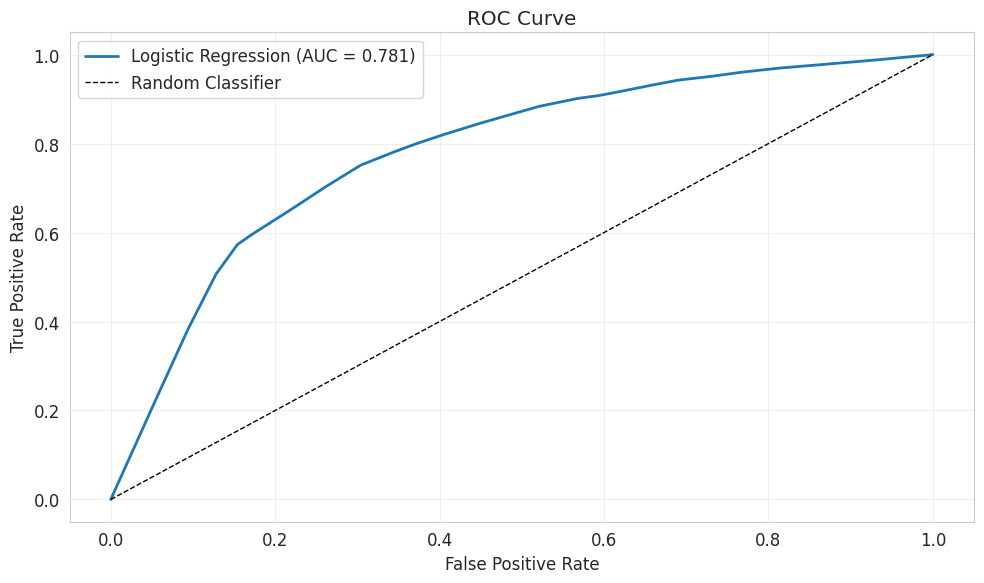

In [48]:
print("Build and Evaluate Logistic Regression Model")
logreg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

logreg.fit(X_train_woe, y_train)

print("Model trained successfully!")
print(f"Intercept: {logreg.intercept_[0]:.4f}")
print("\nCoefficients:")
for feature, coef in zip(X_train_woe.columns, logreg.coef_[0]):
    print(f"  {feature}: {coef:.4f}")

y_pred = logreg.predict(X_val_woe)
y_pred_proba = logreg.predict_proba(X_val_woe)[:, 1]

auc_roc = roc_auc_score(y_val, y_pred_proba)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("\nModel Performance Metrics:")
print(f"  AUC-ROC: {auc_roc:.4f}")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Non-default', 'Default']))
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(cm)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_roc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Scorecard Construction
Scorecard Parameters:
  Target Score: 600
  Target Odds: 50:1
  PDO: 20
  Factor: 28.8539
  Offset: 487.1229

Scorecard Points:
                                    Feature  Points
0                                 Intercept   97.50
1  RevolvingUtilizationOfUnsecuredLines_WoE  -27.21
2               NumberOfTimes90DaysLate_WoE    0.00
3  NumberOfTime30-59DaysPastDueNotWorse_WoE    0.00
4  NumberOfTime60-89DaysPastDueNotWorse_WoE    0.00
5                                   age_WoE  -14.87

Score Statistics (Validation Set):
  Mean: 97.50
  Std: 0.00
  Min: 97.50
  Max: 97.50
  Median: 97.50


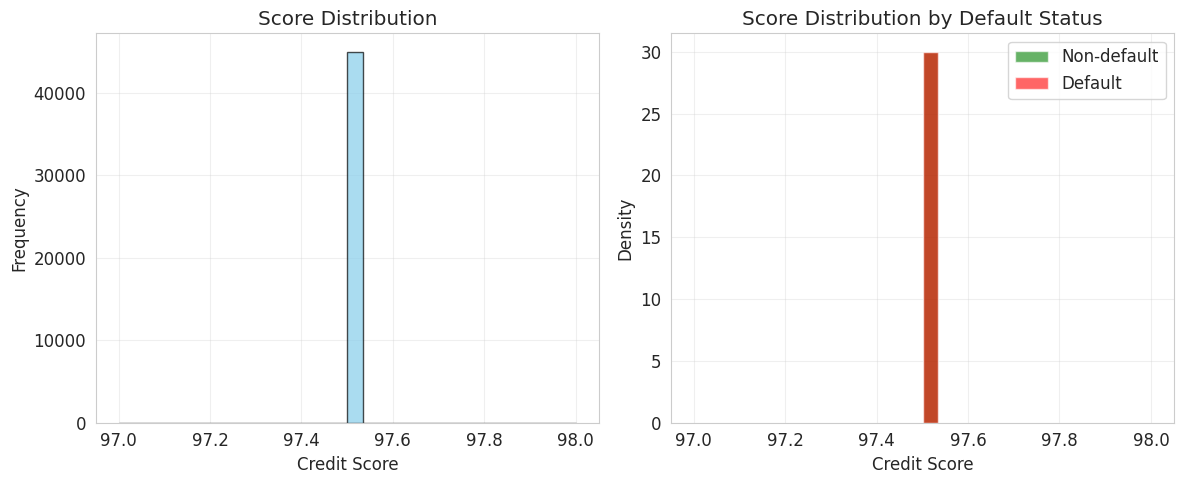

In [49]:
print("Scorecard Construction")
TARGET_SCORE = 600
TARGET_ODDS = 50
PDO = 20

factor = PDO / np.log(2)
offset = TARGET_SCORE - (factor * np.log(TARGET_ODDS))

print(f"Scorecard Parameters:")
print(f"  Target Score: {TARGET_SCORE}")
print(f"  Target Odds: {TARGET_ODDS}:1")
print(f"  PDO: {PDO}")
print(f"  Factor: {factor:.4f}")
print(f"  Offset: {offset:.4f}")

scorecard = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_train_woe.columns),
    'Coefficient': [logreg.intercept_[0]] + list(logreg.coef_[0])
})

n_features = len(scorecard) - 1
scorecard['Points'] = 0.0

scorecard.loc[scorecard['Feature'] == 'Intercept', 'Points'] = (
    (scorecard.loc[scorecard['Feature'] == 'Intercept', 'Coefficient'].values[0] / n_features) * factor +
    offset / n_features
)

feature_mask = scorecard['Feature'] != 'Intercept'
scorecard.loc[feature_mask, 'Points'] = (
    scorecard.loc[feature_mask, 'Coefficient'] * factor
)

print("\nScorecard Points:")
print(scorecard[['Feature', 'Points']].round(2))

def calculate_score(X_woe, scorecard_df):
    scores = np.ones(len(X_woe)) * scorecard_df.loc[
        scorecard_df['Feature'] == 'Intercept', 'Points'
    ].values[0]

    for feature in X_woe.columns:
        if f'{feature}_WoE' in scorecard_df['Feature'].values:
            feature_points = scorecard_df.loc[
                scorecard_df['Feature'] == f'{feature}_WoE', 'Points'
            ].values[0]
            scores += X_woe[feature] * feature_points
    return scores

val_scores = calculate_score(X_val_woe, scorecard)

print(f"\nScore Statistics (Validation Set):")
print(f"  Mean: {val_scores.mean():.2f}")
print(f"  Std: {val_scores.std():.2f}")
print(f"  Min: {val_scores.min():.2f}")
print(f"  Max: {val_scores.max():.2f}")
print(f"  Median: {np.median(val_scores):.2f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(val_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Score Distribution')
plt.grid(alpha=0.3)
plt.subplot(1, 2, 2)
default_scores = val_scores[y_val == 1]
non_default_scores = val_scores[y_val == 0]
plt.hist(non_default_scores, bins=30, alpha=0.6, color='green', label='Non-default', density=True)
plt.hist(default_scores, bins=30, alpha=0.6, color='red', label='Default', density=True)
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Score Distribution by Default Status')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [53]:
print("Population Stability Index (PSI) Analysis")

def calculate_psi_for_small_dataset(expected, actual, n_bins=5):
    combined = np.concatenate([expected, actual])
    n_unique = len(np.unique(combined))
    n_bins = min(n_bins, n_unique // 2)
    n_bins = max(2, n_bins)

    print(f"Using {n_bins} bins for PSI calculation")

    try:
        bins = np.percentile(combined, np.linspace(0, 100, n_bins + 1))
        bins = np.unique(bins)
        if len(bins) < 2:
            bins = np.array([combined.min(), combined.max()])
        bins[0] = -np.inf
        bins[-1] = np.inf
        expected_binned = pd.cut(expected, bins=bins, duplicates='drop')
        actual_binned = pd.cut(actual, bins=bins, duplicates='drop')

    except Exception as e:
        print(f"Quantile binning failed: {e}. Using fixed bins.")
        bins = np.linspace(combined.min(), combined.max(), n_bins + 1)
        bins[0] = -np.inf
        bins[-1] = np.inf
        expected_binned = pd.cut(expected, bins=bins, duplicates='drop')
        actual_binned = pd.cut(actual, bins=bins, duplicates='drop')
    expected_counts = expected_binned.value_counts()
    actual_counts = actual_binned.value_counts()
    all_bins = sorted(set(expected_binned.dropna().unique()).union(
                      set(actual_binned.dropna().unique())))

    expected_pct = pd.Series(0.0, index=all_bins)
    actual_pct = pd.Series(0.0, index=all_bins)

    for bin_val in all_bins:
        expected_pct[bin_val] = (expected_binned == bin_val).sum() / len(expected)
        actual_pct[bin_val] = (actual_binned == bin_val).sum() / len(actual)
    epsilon = 1e-10
    expected_pct = expected_pct + epsilon
    actual_pct = actual_pct + epsilon
    expected_pct = expected_pct / expected_pct.sum()
    actual_pct = actual_pct / actual_pct.sum()
    psi_contributions = (actual_pct - expected_pct) * np.log(actual_pct / expected_pct)
    psi_total = psi_contributions.sum()
    result_df = pd.DataFrame({
        'Bin': [str(b) for b in all_bins],
        'Expected_Count': [(expected_binned == b).sum() for b in all_bins],
        'Actual_Count': [(actual_binned == b).sum() for b in all_bins],
        'Expected_%': expected_pct.values * 100,
        'Actual_%': actual_pct.values * 100,
        'PSI_Contribution': psi_contributions.values
    })

    return psi_total, result_df

try:
    train_scores = calculate_score(X_train_woe, scorecard)
    val_scores = calculate_score(X_val_woe, scorecard)

    print(f"Dataset sizes: Train={len(train_scores)}, Validation={len(val_scores)}")

    psi_total, psi_df = calculate_psi_for_small_dataset(train_scores, val_scores, n_bins=5)

    print(f"\nPSI Value: {psi_total:.6f}")
    print("\nPSI Interpretation:")
    print("  < 0.1: No significant population shift")
    print("  0.1 - 0.25: Moderate shift, monitor closely")
    print("  > 0.25: Significant shift, investigation needed")

    print("\nPSI Analysis Results:")
    print(psi_df.to_string(index=False))

    if len(psi_df) > 1:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        x = range(len(psi_df))
        width = 0.35
        axes[0].bar([i - width/2 for i in x], psi_df['Expected_Count'], width, label='Training', alpha=0.7)
        axes[0].bar([i + width/2 for i in x], psi_df['Actual_Count'], width, label='Validation', alpha=0.7)
        axes[0].set_xlabel('Score Band')
        axes[0].set_ylabel('Count')
        axes[0].set_title('Sample Counts by Score Band')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels([f'Bin {i+1}' for i in x], rotation=45)
        axes[0].legend()
        axes[0].grid(alpha=0.3)

        axes[1].plot(x, psi_df['Expected_%'], 'o-', label='Training %', linewidth=2, markersize=8)
        axes[1].plot(x, psi_df['Actual_%'], 's-', label='Validation %', linewidth=2, markersize=8)
        axes[1].set_xlabel('Score Band')
        axes[1].set_ylabel('Percentage (%)')
        axes[1].set_title('Percentage Distribution')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels([f'Bin {i+1}' for i in x], rotation=45)
        axes[1].legend()
        axes[1].grid(alpha=0.3)

        axes[2].bar(x, psi_df['PSI_Contribution'], color='coral', alpha=0.7)
        axes[2].axhline(y=0.1, color='orange', linestyle='--', label='Threshold: 0.1')
        axes[2].axhline(y=0.25, color='red', linestyle='--', label='Threshold: 0.25')
        axes[2].set_xlabel('Score Band')
        axes[2].set_ylabel('PSI Contribution')
        axes[2].set_title('PSI Contributions')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels([f'Bin {i+1}' for i in x], rotation=45)
        axes[2].legend()
        axes[2].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    print("\nAdditional Statistical Tests:")
    t_stat, t_p = stats.ttest_ind(train_scores, val_scores, equal_var=False)
    print(f"Welch's t-test: t={t_stat:.3f}, p={t_p:.4f}")
    print("\nAdditional Statistical Tests:")
    t_stat, t_p = stats.ttest_ind(train_scores, val_scores, equal_var=False)
    print(f"Welch's t-test: t={t_stat:.3f}, p={t_p:.4f}")
    u_stat, u_p = stats.mannwhitneyu(train_scores, val_scores, alternative='two-sided')
    print(f"Mann-Whitney U test: U={u_stat:.1f}, p={u_p:.4f}")
    ks_stat, ks_p = stats.ks_2samp(train_scores, val_scores)
    print(f"Kolmogorov-Smirnov test: D={ks_stat:.3f}, p={ks_p:.4f}")
    print("\nConclusion:")
    if psi_total < 0.1 and t_p > 0.05 and u_p > 0.05:
        print("Strong evidence of population stability across all tests.")
    elif psi_total < 0.25 and (t_p > 0.05 or u_p > 0.05):
        print("Moderate evidence of stability - monitor population shifts.")
    else:
        print("Evidence suggests significant population shift - investigate further.")

except Exception as e:
    print(f"Error in PSI analysis: {e}")
    print("\nPerforming basic distribution comparison instead:")
    train_scores = calculate_score(X_train_woe, scorecard)
    val_scores = calculate_score(X_val_woe, scorecard)

    print(f"Training scores: mean={train_scores.mean():.2f}, std={train_scores.std():.2f}")
    print(f"Validation scores: mean={val_scores.mean():.2f}, std={val_scores.std():.2f}")

    plt.figure(figsize=(10, 6))
    plt.hist(train_scores, bins=10, alpha=0.5, label='Training', density=True)
    plt.hist(val_scores, bins=10, alpha=0.5, label='Validation', density=True)
    plt.xlabel('Credit Score')
    plt.ylabel('Density')
    plt.title('Score Distribution Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print("\nFor small datasets, PSI may not be reliable.")
    print("Focus on ensuring the score distributions look similar visually.")

Population Stability Index (PSI) Analysis
Dataset sizes: Train=105000, Validation=45000
Using 2 bins for PSI calculation

PSI Value: 0.000000

PSI Interpretation:
  < 0.1: No significant population shift
  0.1 - 0.25: Moderate shift, monitor closely
  > 0.25: Significant shift, investigation needed

PSI Analysis Results:
        Bin  Expected_Count  Actual_Count  Expected_%  Actual_%  PSI_Contribution
(-inf, inf]          105000         45000       100.0     100.0               0.0

Additional Statistical Tests:
Welch's t-test: t=0.000, p=1.0000

Additional Statistical Tests:
Welch's t-test: t=0.000, p=1.0000
Mann-Whitney U test: U=2362500000.0, p=1.0000
Kolmogorov-Smirnov test: D=0.000, p=1.0000

Conclusion:
Strong evidence of population stability across all tests.


# TASK 4: HANDLING CLASS IMBALANCE (20%)

In [54]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

print("Baseline Performance (Current Model)")

baseline_metrics = {
    'AUC-ROC': auc_roc,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

print("Baseline Model (with class_weight='balanced'):")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nRandom Over-Sampling (ROS)")

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_woe, y_train)

print(f"Before ROS: {X_train_woe.shape[0]} samples, class distribution: {np.bincount(y_train)}")
print(f"After ROS: {X_train_ros.shape[0]} samples, class distribution: {np.bincount(y_train_ros)}")

logreg_ros = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
logreg_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = logreg_ros.predict(X_val_woe)
y_pred_proba_ros = logreg_ros.predict_proba(X_val_woe)[:, 1]

ros_metrics = {
    'AUC-ROC': roc_auc_score(y_val, y_pred_proba_ros),
    'Accuracy': accuracy_score(y_val, y_pred_ros),
    'Precision': precision_score(y_val, y_pred_ros),
    'Recall': recall_score(y_val, y_pred_ros),
    'F1-Score': f1_score(y_val, y_pred_ros)
}

print("\nPerformance with Random Over-Sampling:")
for metric, value in ros_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nSMOTE (Synthetic Minority Over-sampling)")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_woe, y_train)

print(f"Before SMOTE: {X_train_woe.shape[0]} samples")
print(f"After SMOTE: {X_train_smote.shape[0]} samples")

logreg_smote = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
logreg_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = logreg_smote.predict(X_val_woe)
y_pred_proba_smote = logreg_smote.predict_proba(X_val_woe)[:, 1]

smote_metrics = {
    'AUC-ROC': roc_auc_score(y_val, y_pred_proba_smote),
    'Accuracy': accuracy_score(y_val, y_pred_smote),
    'Precision': precision_score(y_val, y_pred_smote),
    'Recall': recall_score(y_val, y_pred_smote),
    'F1-Score': f1_score(y_val, y_pred_smote)
}

print("\nPerformance with SMOTE:")
for metric, value in smote_metrics.items():
    print(f"  {metric}: {value:.4f}")

Baseline Performance (Current Model)
Baseline Model (with class_weight='balanced'):
  AUC-ROC: 0.7811
  Accuracy: 0.6995
  Precision: 0.1504
  Recall: 0.7517
  F1-Score: 0.2506

Random Over-Sampling (ROS)
Before ROS: 105000 samples, class distribution: [97982  7018]
After ROS: 195964 samples, class distribution: [97982 97982]

Performance with Random Over-Sampling:
  AUC-ROC: 0.7811
  Accuracy: 0.6995
  Precision: 0.1504
  Recall: 0.7517
  F1-Score: 0.2506

SMOTE (Synthetic Minority Over-sampling)
Before SMOTE: 105000 samples
After SMOTE: 195964 samples

Performance with SMOTE:
  AUC-ROC: 0.7811
  Accuracy: 0.6995
  Precision: 0.1504
  Recall: 0.7517
  F1-Score: 0.2506


Random Under-Sampling (RUS)
Before RUS: 105000 samples
After RUS: 14036 samples

Performance with Random Under-Sampling:
  AUC-ROC: 0.7809
  Accuracy: 0.6995
  Precision: 0.1504
  Recall: 0.7517
  F1-Score: 0.2506

Comparison of All Methods

Performance Comparison:
                       AUC-ROC  Accuracy  Precision  Recall  F1-Score
Baseline                0.7811    0.6995     0.1504  0.7517    0.2506
Random Over-Sampling    0.7811    0.6995     0.1504  0.7517    0.2506
SMOTE                   0.7811    0.6995     0.1504  0.7517    0.2506
Random Under-Sampling   0.7809    0.6995     0.1504  0.7517    0.2506

Best Method for Each Metric:
  AUC-ROC: Baseline (0.7811)
  F1-Score: Baseline (0.2506)
  Recall: Baseline (0.7517)


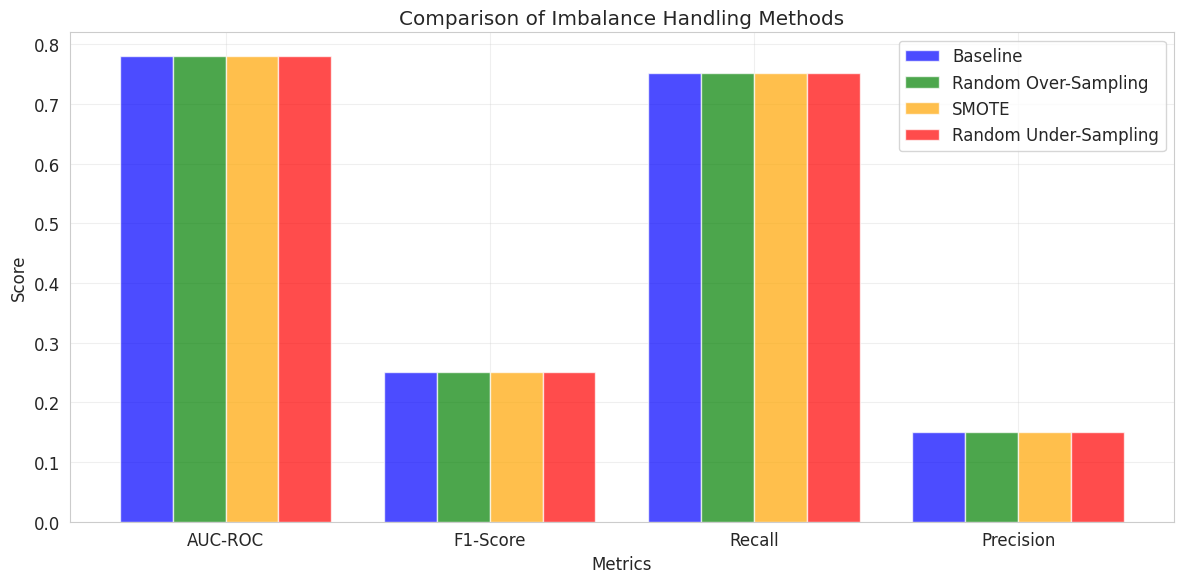

In [55]:
print("Random Under-Sampling (RUS)")

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_woe, y_train)

print(f"Before RUS: {X_train_woe.shape[0]} samples")
print(f"After RUS: {X_train_rus.shape[0]} samples")

logreg_rus = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
logreg_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = logreg_rus.predict(X_val_woe)
y_pred_proba_rus = logreg_rus.predict_proba(X_val_woe)[:, 1]

rus_metrics = {
    'AUC-ROC': roc_auc_score(y_val, y_pred_proba_rus),
    'Accuracy': accuracy_score(y_val, y_pred_rus),
    'Precision': precision_score(y_val, y_pred_rus),
    'Recall': recall_score(y_val, y_pred_rus),
    'F1-Score': f1_score(y_val, y_pred_rus)
}

print("\nPerformance with Random Under-Sampling:")
for metric, value in rus_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nComparison of All Methods")
comparison_df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Random Over-Sampling': ros_metrics,
    'SMOTE': smote_metrics,
    'Random Under-Sampling': rus_metrics
}).T

print("\nPerformance Comparison:")
print(comparison_df.round(4))
print("\nBest Method for Each Metric:")
for metric in ['AUC-ROC', 'F1-Score', 'Recall']:
    best_method = comparison_df[metric].idxmax()
    best_value = comparison_df.loc[best_method, metric]
    print(f"  {metric}: {best_method} ({best_value:.4f})")

metrics_to_plot = ['AUC-ROC', 'F1-Score', 'Recall', 'Precision']
x = np.arange(len(metrics_to_plot))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

for i, (method, color) in enumerate(zip(
    ['Baseline', 'Random Over-Sampling', 'SMOTE', 'Random Under-Sampling'],
    ['blue', 'green', 'orange', 'red']
)):
    values = [comparison_df.loc[method, metric] for metric in metrics_to_plot]
    ax.bar(x + i*width - 1.5*width, values, width, label=method, color=color, alpha=0.7)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Imbalance Handling Methods')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()